In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
data = yf.download('MSFT',start = "2000-01-01",end="2023-12-31")

data = data[['Close']]

scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))


[*********************100%%**********************]  1 of 1 completed
<ipython-input-2-95ba8421a7e4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))


In [ ]:
SEQUENCE_SIZE = 15

def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)

    return np.array(x), np.array(y)

X, y = to_sequences(SEQUENCE_SIZE, data['Close'].values)

In [ ]:
split_index = int(len(data) * 0.8)

X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]
X_train = X_train.reshape(-1, SEQUENCE_SIZE, 1)
X_test = X_test.reshape(-1, SEQUENCE_SIZE, 1)

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
batch_size = 64
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

#LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = None

    def forward(self, input_seq):
        self.hidden_cell
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
def train_model(model, train_loader, epochs=600):
    loss_function = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    for epoch in range(epochs):
        model.train()
        for seq, labels in train_loader:
            seq = seq.to('cuda')
            labels = labels.to('cuda')
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, seq.size(0), model.hidden_layer_size).to('cuda'),
                                 torch.zeros(1, seq.size(0), model.hidden_layer_size).to('cuda'))
            y_pred = model(seq)

            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
        if epoch % 50 == 0:
            print(f'Epoch: {epoch} Loss: {single_loss.item():.8f}')

    return model

In [ ]:
# Train multiple LSTM models
num_models = 5
models = []
for i in range(num_models):
    model = LSTM(input_size=1).to('cuda')
    model.apply(init_weights)
    trained_model = train_model(model, train_loader)
    models.append(trained_model)
    torch.save(trained_model.state_dict(), f'lstm_model_{i}.pth')


<ipython-input-7-f9c2b1da9c33>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss: 0.00383307
Epoch: 50 Loss: 0.00372636
Epoch: 100 Loss: 0.00162667
Epoch: 150 Loss: 0.00043558
Epoch: 200 Loss: 0.00018253
Epoch: 250 Loss: 0.00014937
Epoch: 300 Loss: 0.00014502
Epoch: 350 Loss: 0.00014426
Epoch: 400 Loss: 0.00014411
Epoch: 450 Loss: 0.00014407
Epoch: 500 Loss: 0.00014407
Epoch: 550 Loss: 0.00014407


<ipython-input-7-f9c2b1da9c33>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Epoch: 0 Loss: 0.00531807
Epoch: 50 Loss: 0.00438949
Epoch: 100 Loss: 0.00188615
Epoch: 150 Loss: 0.00050095
Epoch: 200 Loss: 0.00019413
Epoch: 250 Loss: 0.00015101
Epoch: 300 Loss: 0.00014510
Epoch: 350 Loss: 0.00014403
Epoch: 400 Loss: 0.00014380
Epoch: 450 Loss: 0.00014374
Epoch: 500 Loss: 0.00014373
Epoch: 550 Loss: 0.00014372
Epoch: 0 Loss: 0.00388432
Epoch: 50 Loss: 0.00400644
Epoch: 100 Loss: 0.00195065
Epoch: 150 Loss: 0.00055613
Epoch: 200 Loss: 0.00020569
Epoch: 250 Loss: 0.00015231
Epoch: 300 Loss: 0.00014499
Epoch: 350 Loss: 0.00014370
Epoch: 400 Loss: 0.00014342
Epoch: 450 Loss: 0.00014335
Epoch: 500 Loss: 0.00014334
Epoch: 550 Loss: 0.00014334
Epoch: 0 Loss: 0.00476615
Epoch: 50 Loss: 0.00451372
Epoch: 100 Loss: 0.00173441
Epoch: 150 Loss: 0.00040198
Epoch: 200 Loss: 0.00017092
Epoch: 250 Loss: 0.00014704
Epoch: 300 Loss: 0.00014439
Epoch: 350 Loss: 0.00014397
Epoch: 400 Loss: 0.00014390
Epoch: 450 Loss: 0.00014388
Epoch: 500 Loss: 0.00014388
Epoch: 550 Loss: 0.00014388
E

In [ ]:
def predict_ensemble(models, test_loader):
    y_pred_ensemble = []
    for seq, _ in test_loader:
        seq = seq.to('cuda')
        preds = []
        for model in models:
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to('cuda'),
                                 torch.zeros(1, 1, model.hidden_layer_size).to('cuda'))
            with torch.no_grad():
                preds.append(model(seq).item())
        y_pred_ensemble.append(np.mean(preds))
    return y_pred_ensemble

In [13]:
y_pred_ensemble = predict_ensemble(models, test_loader)

In [14]:
y_test_inverse = scaler.inverse_transform(np.hstack((np.zeros((len(y_test), 3)), y_test.reshape(-1, 1))))[:, 3]
y_pred_ensemble_inverse = scaler.inverse_transform(np.hstack((np.zeros((len(y_pred_ensemble), 3)), np.array(y_pred_ensemble).reshape(-1, 1))))[:, 3]

In [15]:
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_ensemble_inverse))
r_squared = r2_score(y_test_inverse, y_pred_ensemble_inverse)
print(f'RMSE: {rmse}')
print(f'R-squared: {r_squared}')

RMSE: 11.81466194042914
R-squared: 0.9696531027800096


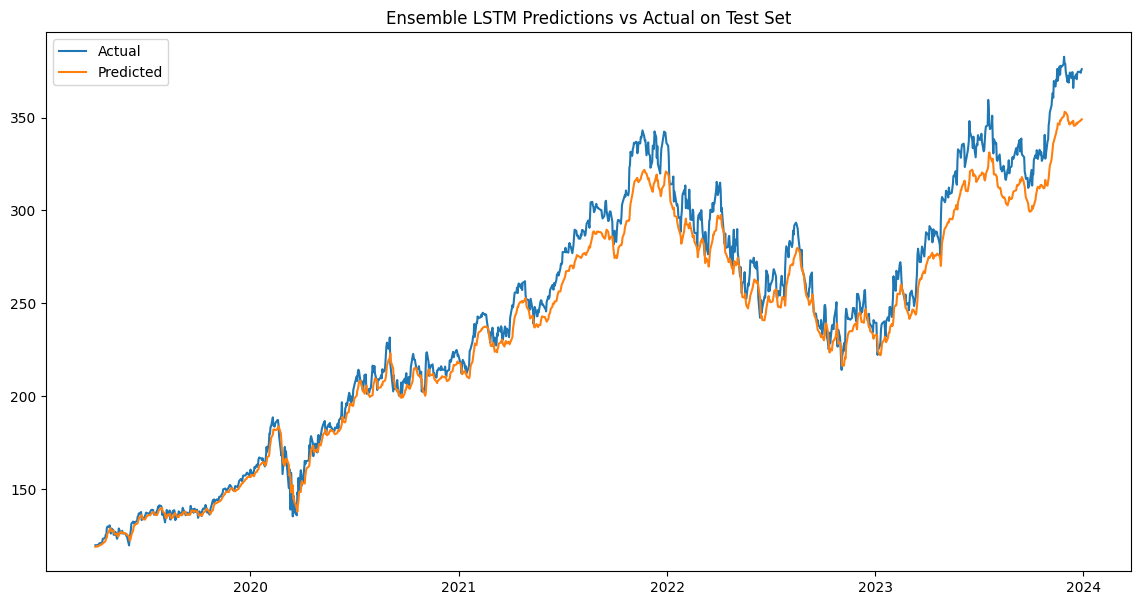

In [16]:
time_test = data.index[split_index + SEQUENCE_SIZE:]
plt.figure(figsize=(14, 7))
plt.plot(time_test, y_test_inverse, label='Actual')
plt.plot(time_test, y_pred_ensemble_inverse, label='Predicted')
plt.legend()
plt.title('Ensemble LSTM Predictions vs Actual on Test Set')
plt.show()

In [17]:
new_data = yf.download('AAPL', start='2000-01-01', end='2023-12-31')
new_data = new_data[['Close']]
new_data['Close'] = scaler.transform(new_data['Close'].values.reshape(-1, 1))

X_new, y_new = to_sequences(SEQUENCE_SIZE, new_data['Close'].values)
X_new = X_new.reshape(-1, SEQUENCE_SIZE, 1)

test_dataset_new = TimeSeriesDataset(X_new, y_new)
test_loader_new = DataLoader(test_dataset_new, batch_size=1, shuffle=False)

num_models = 5
models_loaded = []
for i in range(num_models):
    model = LSTM(input_size=1).to('cuda')
    model.load_state_dict(torch.load(f'lstm_model_{i}.pth'))
    models_loaded.append(model)

y_pred_ensemble_new = predict_ensemble(models_loaded, test_loader_new)

y_test_new_inverse = scaler.inverse_transform(
    np.hstack((np.zeros((len(y_new), 3)), y_new.reshape(-1, 1))))[:, 3]
y_pred_ensemble_new_inverse = scaler.inverse_transform(
    np.hstack((np.zeros((len(y_pred_ensemble_new), 3)), np.array(y_pred_ensemble_new).reshape(-1, 1))))[:, 3]

[*********************100%%**********************]  1 of 1 completed
<ipython-input-17-a84930518018>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Close'] = scaler.transform(new_data['Close'].values.reshape(-1, 1))


In [18]:
rmse_new = np.sqrt(mean_squared_error(y_test_new_inverse, y_pred_ensemble_new_inverse))
r_squared_new = r2_score(y_test_new_inverse, y_pred_ensemble_new_inverse)
print(f'New RMSE: {rmse_new}')
print(f'New R-squared: {r_squared_new}')

New RMSE: 2.110626256607944
New R-squared: 0.9982926771250232


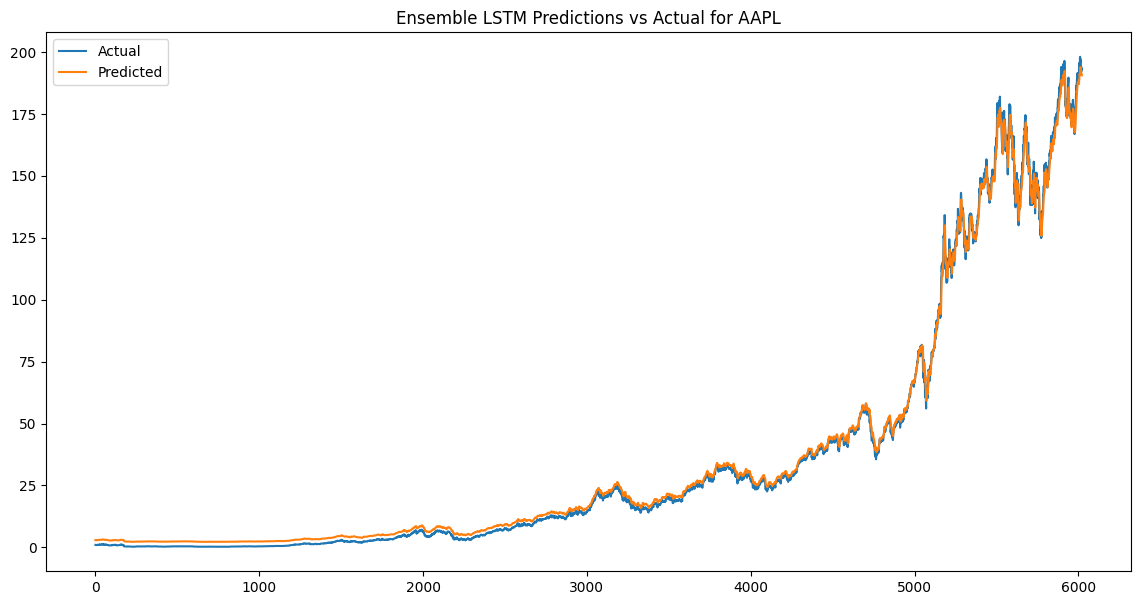

In [19]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_new_inverse, label='Actual')
plt.plot(y_pred_ensemble_new_inverse, label='Predicted')
plt.legend()
plt.title('Ensemble LSTM Predictions vs Actual for AAPL')
plt.show()

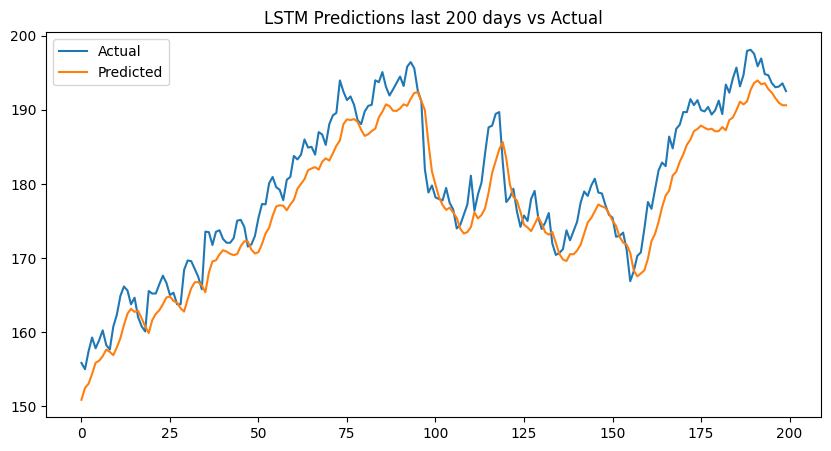

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_new_inverse[-200:], label='Actual')
plt.plot(y_pred_ensemble_new_inverse[-200:], label='Predicted')
plt.legend()
plt.title('LSTM Predictions last 200 days vs Actual')
plt.show()

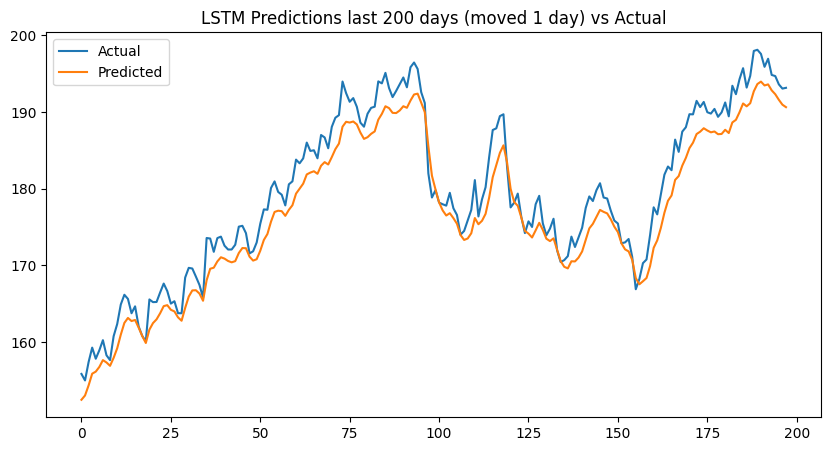

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_new_inverse[-200:-2], label='Actual')
plt.plot(y_pred_ensemble_new_inverse[-199:-1], label='Predicted')
plt.legend()
plt.title('LSTM Predictions last 200 days (moved 1 day) vs Actual')
plt.show()

# RNN

In [22]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(VanillaRNN, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = nn.RNN(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        h0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
        rnn_out, _ = self.rnn(input_seq, h0)
        predictions = self.linear(rnn_out[:, -1])
        return predictions

In [23]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [24]:
def train_model(model, train_loader, epochs=600):
    loss_function = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    for epoch in range(epochs):
        model.train()
        for seq, labels in train_loader:
            seq = seq.to('cuda')
            labels = labels.to('cuda')
            optimizer.zero_grad()
            y_pred = model(seq)
            labels = labels.reshape((y_pred.shape[0], 1))
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
        # Print epoch and loss
        if epoch % 50 == 0:
            print(f'Epoch: {epoch} Loss: {single_loss.item():.8f}')
    return model


In [25]:
num_models = 5
rnn_models = []
for i in range(num_models):
    model = VanillaRNN(input_size=1).to('cuda')
    model.apply(init_weights)
    print(f"Training Vanilla RNN model {i+1}")
    trained_model = train_model(model, train_loader, epochs=200)
    rnn_models.append(trained_model)
    torch.save(trained_model.state_dict(), f'vanilla_rnn_model_{i}.pth')


Training Vanilla RNN model 1
Epoch: 0 Loss: 0.00030481
Epoch: 50 Loss: 0.00074537
Epoch: 100 Loss: 0.00004570
Epoch: 150 Loss: 0.00000953
Training Vanilla RNN model 2
Epoch: 0 Loss: 0.00055096
Epoch: 50 Loss: 0.00214325
Epoch: 100 Loss: 0.00041928
Epoch: 150 Loss: 0.00001553
Training Vanilla RNN model 3
Epoch: 0 Loss: 0.00023074
Epoch: 50 Loss: 0.00116421
Epoch: 100 Loss: 0.00013392
Epoch: 150 Loss: 0.00001059
Training Vanilla RNN model 4
Epoch: 0 Loss: 0.00029381
Epoch: 50 Loss: 0.00197064
Epoch: 100 Loss: 0.00027160
Epoch: 150 Loss: 0.00001102
Training Vanilla RNN model 5
Epoch: 0 Loss: 0.00070853
Epoch: 50 Loss: 0.00204903
Epoch: 100 Loss: 0.00026825
Epoch: 150 Loss: 0.00001056


In [26]:
def predict_ensemble(models, test_loader):
    y_pred_ensemble = []
    for seq, _ in test_loader:
        seq = seq.to('cuda')
        preds = []
        for model in models:
            with torch.no_grad():
                preds.append(model(seq).item())
        y_pred_ensemble.append(np.mean(preds))
    return y_pred_ensemble

In [27]:
y_pred_ensemble_rnn = predict_ensemble(rnn_models, test_loader)

In [28]:
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_ensemble_rnn_inverse = scaler.inverse_transform(np.array(y_pred_ensemble_rnn).reshape(-1, 1))

In [29]:
rmse_rnn = np.sqrt(mean_squared_error(y_test_inverse, y_pred_ensemble_rnn_inverse))
r_squared_rnn = r2_score(y_test_inverse, y_pred_ensemble_rnn_inverse)
print(f'RNN RMSE: {rmse_rnn}')
print(f'RNN R-squared: {r_squared_rnn}')

RNN RMSE: 5.8398223777989795
RNN R-squared: 0.9925856860657962


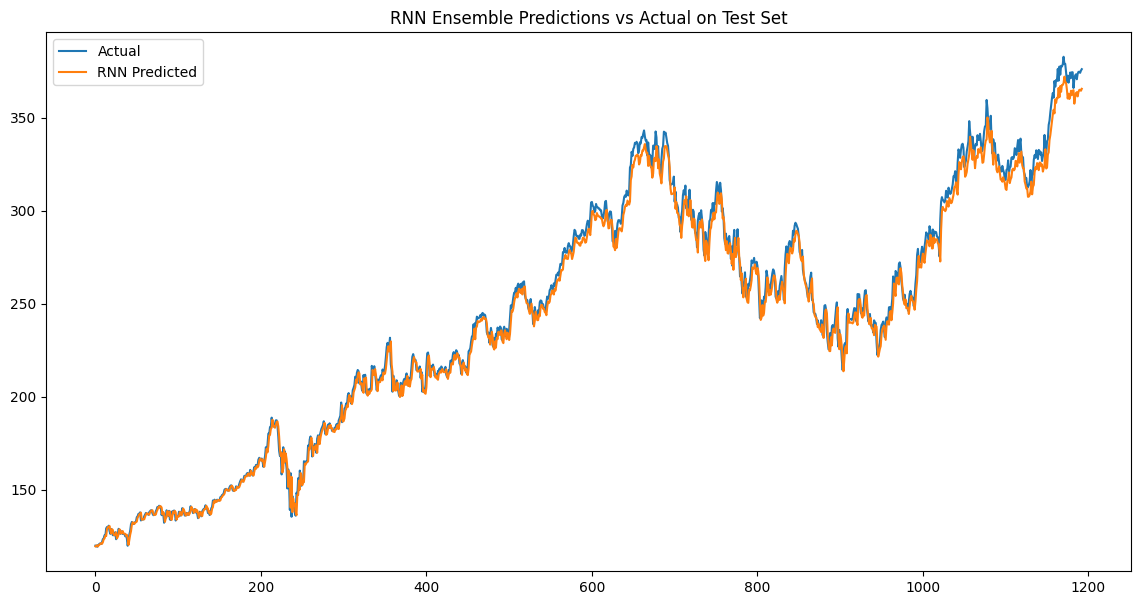

In [36]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual')
plt.plot(y_pred_ensemble_rnn_inverse, label='RNN Predicted')
plt.legend()
plt.title('RNN Ensemble Predictions vs Actual on Test Set')
plt.show()

In [31]:
new_data = yf.download('AAPL', start='2000-01-01', end='2023-12-31')
new_data = new_data[['Close']]
new_data['Close'] = scaler.transform(new_data['Close'].values.reshape(-1, 1))

X_new, y_new = to_sequences(SEQUENCE_SIZE, new_data['Close'].values)
X_new = X_new.reshape(-1, SEQUENCE_SIZE, 1)

test_dataset_new = TimeSeriesDataset(X_new, y_new)
test_loader_new = DataLoader(test_dataset_new, batch_size=1, shuffle=False)

rnn_models_loaded = []
for i in range(num_models):
    model = VanillaRNN(input_size=1).to('cuda')
    model.load_state_dict(torch.load(f'vanilla_rnn_model_{i}.pth'))
    rnn_models_loaded.append(model)

y_pred_ensemble_new_rnn = predict_ensemble(rnn_models_loaded, test_loader_new)

y_test_new_inverse = scaler.inverse_transform(y_new.reshape(-1, 1))
y_pred_ensemble_new_rnn_inverse = scaler.inverse_transform(np.array(y_pred_ensemble_new_rnn).reshape(-1, 1))


[*********************100%%**********************]  1 of 1 completed
<ipython-input-31-d2745a1bc627>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Close'] = scaler.transform(new_data['Close'].values.reshape(-1, 1))


In [32]:
rmse_new_rnn = np.sqrt(mean_squared_error(y_test_new_inverse, y_pred_ensemble_new_rnn_inverse))
r_squared_new_rnn = r2_score(y_test_new_inverse, y_pred_ensemble_new_rnn_inverse)
print(f'New RNN RMSE: {rmse_new_rnn}')
print(f'New RNN R-squared: {r_squared_new_rnn}')

New RNN RMSE: 1.1335351560364804
New RNN R-squared: 0.9995075490560918


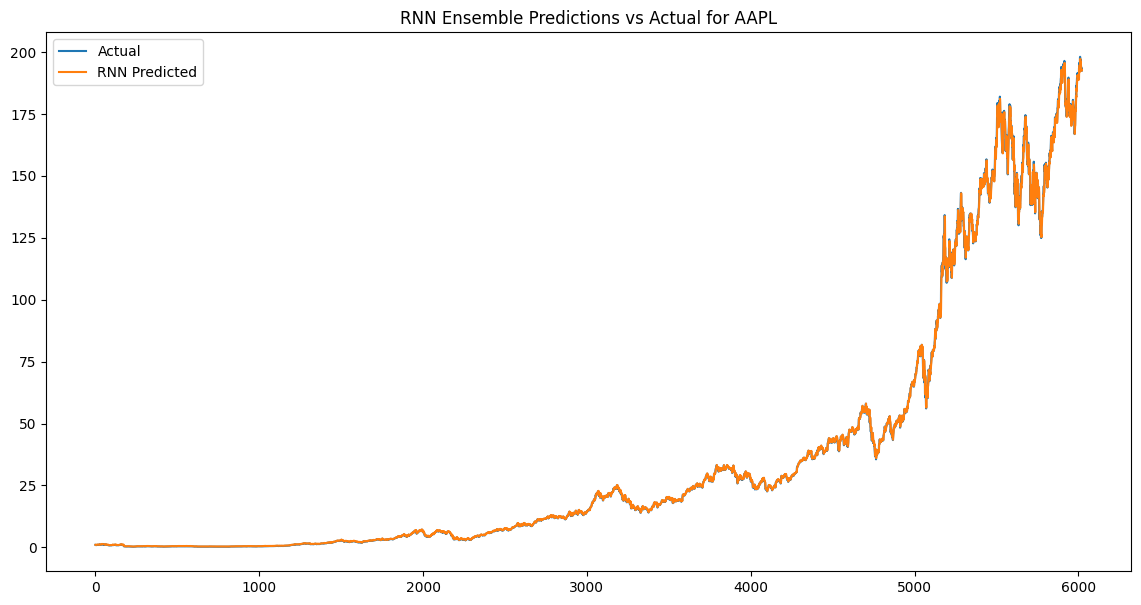

In [33]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_new_inverse, label='Actual')
plt.plot(y_pred_ensemble_new_rnn_inverse, label='RNN Predicted')
plt.legend()
plt.title('RNN Ensemble Predictions vs Actual for AAPL')
plt.show()

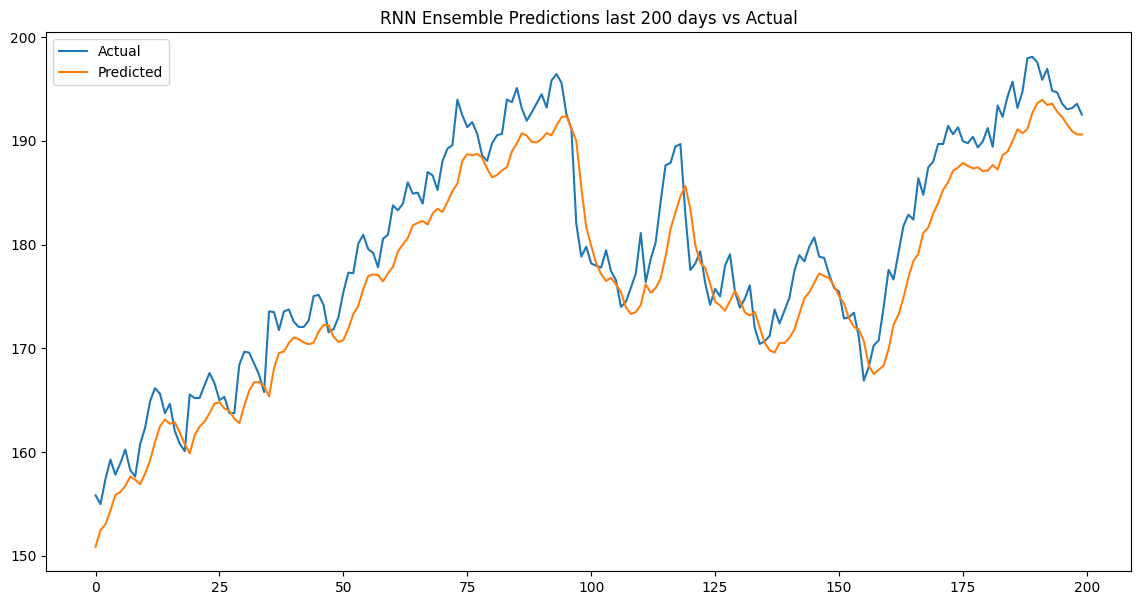

In [34]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_new_inverse[-200:], label='Actual')
plt.plot(y_pred_ensemble_new_inverse[-200:], label='Predicted')
plt.legend()
plt.title('RNN Ensemble Predictions last 200 days vs Actual')
plt.show()

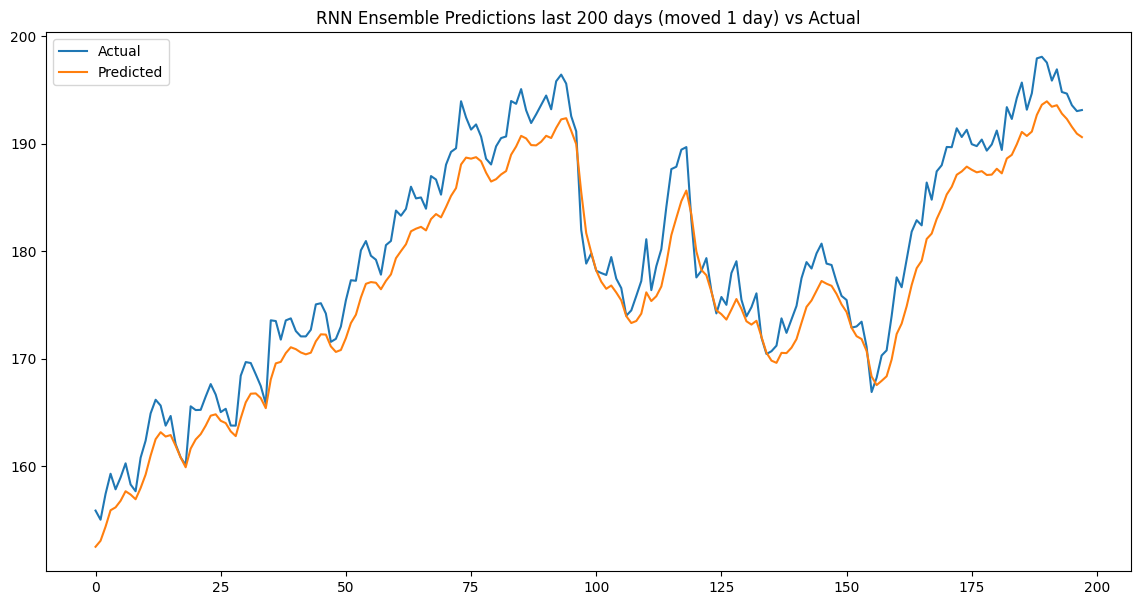

In [35]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_new_inverse[-200:-2], label='Actual')
plt.plot(y_pred_ensemble_new_inverse[-199:-1], label='Predicted')
plt.legend()
plt.title('RNN Ensemble Predictions last 200 days (moved 1 day) vs Actual')
plt.show()